In [1]:
# Import the tables of the data set as dataframes.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

DATA_DIR = 'data'

**Research question:**

## Task 1: Data Preprocessing

In [2]:
# Load the data
activity = pd.read_csv(f'{DATA_DIR}/activity.csv')
activity_sizes = {'Original': len(activity)}

# Cast timestamps to datetime
activity['activity_started'] = pd.to_datetime(activity['activity_started'], unit='s')
activity['activity_completed'] = pd.to_datetime(activity['activity_completed'], unit='s')
activity['activity_updated'] = pd.to_datetime(activity['activity_updated'], unit='s')

# Remove entries where the activity_completed was before the activity_started
activity = activity[activity['activity_completed'] > activity['activity_started']]
activity_sizes['After removing missing or inconcistent completion'] = len(activity)

# Create a column with the duration of the activity
activity['activity_duration'] = activity['activity_completed'] - activity['activity_started']
activity['activity_duration_minutes'] = activity['activity_duration'].dt.total_seconds() / 60

# Remove entries where the activity_completed is more than 24 hours after the activity_started
activity = activity[activity['activity_duration_minutes'] <= 24 * 60]
activity_sizes['After removing duration > 24h'] = len(activity)

# Compute IQR bounds for filtering
Q1 = activity['activity_duration_minutes'].quantile(0.25)
Q3 = activity['activity_duration_minutes'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
# Filter outliers
activity = activity[
    (activity['activity_duration_minutes'] >= lower_bound) &
    (activity['activity_duration_minutes'] <= upper_bound)
]

# Dataset evolution
print("Data set sizes at each stage:")
for stage, size in activity_sizes.items():
    print(f"- {stage}: {size} entries ({size / activity_sizes['Original'] * 100:.2f}%)")

user_daily_activity = activity.copy(deep=True)

# Create new column for activity started day
user_daily_activity['active_day'] = pd.to_datetime(user_daily_activity['activity_started'].dt.date)

# Drop duplicates in user_id, active_day
user_daily_activity.drop_duplicates(subset=['user_id', 'active_day'], inplace=True, keep='first')

# Compute gaps between active days for each user
user_daily_activity.sort_values(['user_id', 'active_day'], inplace=True)
user_daily_activity['previous_day'] = user_daily_activity.groupby('user_id')['active_day'].shift(1)
user_daily_activity['gap_days'] = (user_daily_activity['active_day'] - user_daily_activity['previous_day']).dt.days

# Keep only relevnt columns
columns = ['user_id', 'active_day', 'gap_days']
user_daily_activity = user_daily_activity[columns]

# Compute the median of gap_days per user
user_activity = user_daily_activity.groupby('user_id')['gap_days'].median().reset_index()
user_activity.rename(columns={'gap_days': 'median_gap_days'}, inplace=True)

# Add the number of active days of that user (count)
user_activity['active_days_count'] = user_daily_activity.groupby('user_id')['active_day'].count().values

# Add the median activity duration of that user (activity_completed - activity_started) only when activity_completed is not missing
user_activity['median_activity_duration'] = activity.groupby('user_id').apply(
    lambda x: (x['activity_completed'] - x['activity_started']).median()
).reset_index(drop=True)

# Add the number of activities of that user (count)
user_activity['activities_count'] = activity.groupby('user_id')['activity_id'].count().values
# Add the number of unique activity types of that user
user_activity['activity_types_count'] = activity.groupby('user_id')['activity_type'].nunique().values

# Convert timedelta to minutes
user_activity['median_activity_duration_minutes'] = user_activity['median_activity_duration'].dt.total_seconds() / 60

# Drop the original timedelta column
user_activity.drop(columns=['median_activity_duration'], inplace=True)

print("Activity per User:")
display(user_activity.head())
print("Shape:", user_activity.shape)



Data set sizes at each stage:
- Original: 72897 entries (100.00%)
- After removing missing or inconcistent completion: 38881 entries (53.34%)
- After removing duration > 24h: 26217 entries (35.96%)
Activity per User:


/var/folders/q0/bnk2bs5j0lj3ph23b8l_1p100000gn/T/ipykernel_35240/2398963956.py:64: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  user_activity['median_activity_duration'] = activity.groupby('user_id').apply(


,user_id,median_gap_days,active_days_count,activities_count,activity_types_count,median_activity_duration_minutes
0,1,4.0,11,19,2,4.716667
1,4,7.5,7,31,1,2.266667
2,6,7.0,9,30,2,7.658333
3,7,4.0,16,30,2,13.583333
4,9,12.0,8,26,2,6.466667


Shape: (843, 6)


New preprocessing starts here

In [3]:
# TODO: Monter ceci avant la creation de user_activity

# Remove outliers in activity_started with IQR method
print("Length before removing outliers in activity_started:", activity.shape[0])
Q1 = activity['activity_started'].quantile(0.25)
Q3 = activity['activity_started'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
activity = activity[
    (activity['activity_started'] >= lower_bound) &
    (activity['activity_started'] <= upper_bound)
]
print("Length after removing outliers in activity_started:", activity.shape[0])

Length before removing outliers in activity_started: 22754
Length after removing outliers in activity_started: 21803


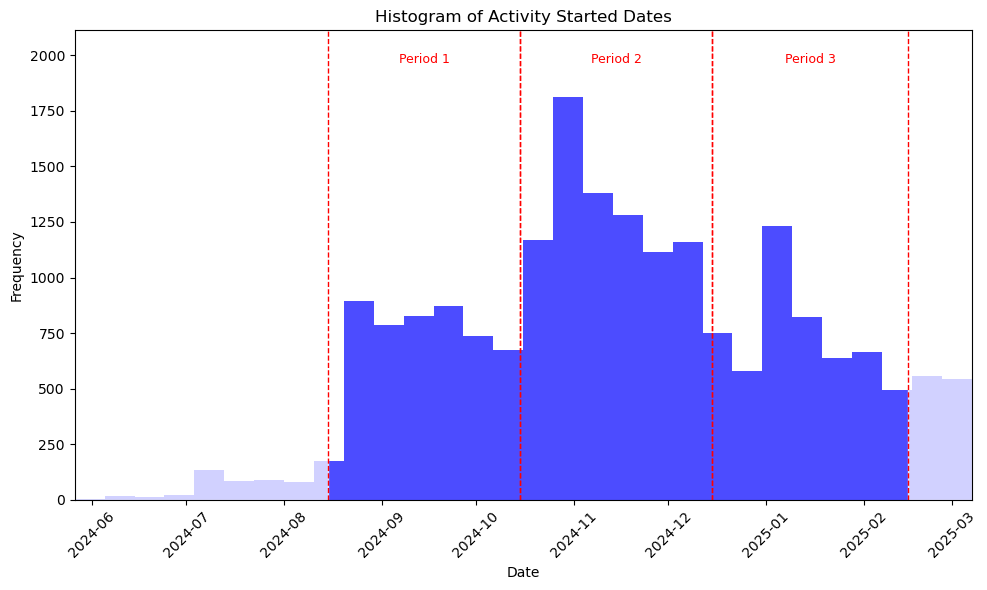

In [4]:
# Define your dynamic periods
periods = [
    ('2024-08-15', '2024-10-15', 'Period 1'),
    ('2024-10-15', '2024-12-15', 'Period 2'),
    ('2024-12-15', '2025-02-15', 'Period 3'),
    # Add more periods here without modifying any code below
]

# Prepare histogram data
min_date = activity['activity_started'].min()
max_date = activity['activity_started'].max()

# Plot histogram with explicit range starting from min_date
plt.figure(figsize=(10, 6))
counts, bins, patches = plt.hist(activity['activity_started'], bins=30, color='blue', alpha=0.7, range=(min_date, max_date))

# Slightly shorten bars to leave space for text labels
for patch in patches:
    patch.set_height(patch.get_height() * 0.9)

# Convert period boundaries to timestamps
period_bounds = [(pd.Timestamp(start), pd.Timestamp(end)) for start, end, _ in periods]
first_start = period_bounds[0][0]
last_end = period_bounds[-1][1]

# Shade before first and after last period
color, alpha = 'white', 0.75
if min_date < first_start:
    plt.axvspan(min_date, first_start, color=color, alpha=alpha)
if max_date > last_end:
    plt.axvspan(last_end, max_date, color=color, alpha=alpha)

period_colors = 'red'

# Add vertical dashed lines and period labels
for (start_ts, end_ts), (_, _, period_name) in zip(period_bounds, periods):
    midpoint = start_ts + (end_ts - start_ts) / 2
    plt.axvline(start_ts, color=period_colors, linestyle='--', linewidth=1)
    plt.axvline(end_ts, color=period_colors, linestyle='--', linewidth=1)

    # Add period name slightly above shortened bars
    plt.text(midpoint, max(counts), period_name,
             ha='center', va='top', fontsize=9, color=period_colors,
             bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

plt.title('Histogram of Activity Started Dates')
plt.xlabel('Date')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.xlim(min_date, max_date)
plt.grid(False)
plt.tight_layout()
plt.show()



In [5]:
def create_user_activity_by_period(activity_df, periods):
    """
    Creates user activity dataframes separated by time periods.

    Parameters:
    -----------
    activity_df : pandas DataFrame
        The original activity dataframe.
    periods : list of tuples
        List of (start_date, end_date, period_name) tuples defining the periods.

    Returns:
    --------
    dict
        Dictionary of user_activity dataframes for each period.
    """
    user_activity_periods = {}

    for start_date, end_date, period_name in periods:
        period_activity = activity_df[
            (activity_df['activity_started'] >= pd.Timestamp(start_date)) &
            (activity_df['activity_started'] < pd.Timestamp(end_date))
        ].copy(deep=True)

        if period_activity.empty:
            continue

        user_daily_activity = period_activity.copy()
        user_daily_activity['active_day'] = pd.to_datetime(user_daily_activity['activity_started'].dt.date)
        user_daily_activity.drop_duplicates(subset=['user_id', 'active_day'], inplace=True, keep='first')
        user_daily_activity.sort_values(['user_id', 'active_day'], inplace=True)
        user_daily_activity['previous_day'] = user_daily_activity.groupby('user_id')['active_day'].shift(1)
        user_daily_activity['gap_days'] = (user_daily_activity['active_day'] - user_daily_activity['previous_day']).dt.days

        user_daily_activity = user_daily_activity[['user_id', 'active_day', 'gap_days']]

        user_activity = user_daily_activity.groupby('user_id')['gap_days'].median().reset_index()
        user_activity.rename(columns={'gap_days': 'median_gap_days'}, inplace=True)
        user_activity['active_days_count'] = user_daily_activity.groupby('user_id')['active_day'].count().values

        duration_median = (period_activity['activity_completed'] - period_activity['activity_started']).groupby(period_activity['user_id']).median()

        user_activity['median_activity_duration'] = duration_median.reset_index(drop=True)

        user_activity['activities_count'] = period_activity.groupby('user_id')['activity_id'].count().values
        user_activity['activity_types_count'] = period_activity.groupby('user_id')['activity_type'].nunique().values

        user_activity['median_activity_duration_minutes'] = user_activity['median_activity_duration'].dt.total_seconds() / 60
        user_activity.drop(columns=['median_activity_duration'], inplace=True)
        user_activity['period'] = period_name

        user_activity_periods[period_name] = user_activity

    return user_activity_periods

# Create the period user activity dict
user_activity_periods = create_user_activity_by_period(activity, periods)

# Concatenate all into one dataframe dynamically
all_periods_user_activity = pd.concat(user_activity_periods.values(), ignore_index=True)
print("\nUser activity across all periods:")
display(all_periods_user_activity.head())
print(f"Shape: {all_periods_user_activity.shape}")
print("\n")

# Number of unique users in each period
for period_name, user_activity_df in user_activity_periods.items():
    unique_users = user_activity_df['user_id'].nunique()
    print(f"Unique users in {period_name}: {unique_users}")
print("\n")

# Continous periods pairs
period_pairs = []
for i in range(len(periods) - 1):
    period1 = periods[i][2]
    period2 = periods[i + 1][2]
    period_pairs.append((period1, period2))
    
# Number of unique users in pairs of periods
for period1, period2 in period_pairs:
    users_period1 = user_activity_periods[period1]['user_id'].unique()
    users_period2 = user_activity_periods[period2]['user_id'].unique()
    common_users = len(set(users_period1) & set(users_period2))
    print(f"Common users between {period1} and {period2}: {common_users}")


User activity across all periods:


,user_id,median_gap_days,active_days_count,activities_count,activity_types_count,median_activity_duration_minutes,period
0,128,NaN,1,6,2,1.525000,Period 1
1,129,NaN,1,1,1,1.850000,Period 1
2,130,NaN,1,66,4,0.375000,Period 1
3,131,NaN,1,11,2,0.600000,Period 1
4,142,NaN,1,9,2,6.483333,Period 1


Shape: (1409, 7)


Unique users in Period 1: 427
Unique users in Period 2: 565
Unique users in Period 3: 417


Common users between Period 1 and Period 2: 314
Common users between Period 2 and Period 3: 310


In [45]:
import plotly.graph_objects as go

# Periods and user data
periods = ['Period 1', 'Period 2', 'Period 3']
user_counts = {'Period 1': 427, 'Period 2': 565, 'Period 3': 417}
common_users = {('Period 1', 'Period 2'): 314, ('Period 2', 'Period 3'): 310}

# Label and node setup
label_list, node_colors, node_x, node_y = [], [], [], []
label_index = {}

# Period nodes
for i, p in enumerate(periods):
    label_list.append(f'{p} ({user_counts[p]})')
    label_index[p] = len(label_list) - 1
    node_colors.append("#4c72b0")
    node_x.append(i / (len(periods) - 1))
    node_y.append(0.1)

# Dropout nodes
for i, p in enumerate(periods[:-1]):
    drop_label = f"{p} dropout"
    label_list.append(drop_label)
    label_index[f"{p}_dropout"] = len(label_list) - 1
    node_colors.append("#d62728")
    node_x.append((i + 1) / (len(periods) - 1))  # Shifted to next column
    node_y.append(0.7)

# Hidden "new" joiner nodes
for i, p in enumerate(periods[1:], start=1):
    label_list.append("")  # empty label
    label_index[f"{p}_new"] = len(label_list) - 1
    node_colors.append("rgba(0,0,0,0)")  # fully transparent
    node_x.append(i / (len(periods) - 1))
    node_y.append(1.0)  # offscreen

# Links
sources, targets, values, link_colors, link_labels = [], [], [], [], []

for i in range(len(periods) - 1):
    p1, p2 = periods[i], periods[i + 1]
    total_p1 = user_counts[p1]
    total_p2 = user_counts[p2]
    n_common = common_users[(p1, p2)]
    n_dropout = total_p1 - n_common
    n_new = total_p2 - n_common

    # Main transition
    sources.append(label_index[p1])
    targets.append(label_index[p2])
    values.append(n_common)
    link_colors.append("rgba(100,149,237,0.5)")
    link_labels.append(f"{n_common} continuing")

    # Dropout link
    sources.append(label_index[p1])
    targets.append(label_index[f"{p1}_dropout"])
    values.append(n_dropout)
    link_colors.append("rgba(220,20,60,0.3)")
    link_labels.append(f"{n_dropout} dropped")

    # Hidden new joiners
    sources.append(label_index[f"{p2}_new"])
    targets.append(label_index[p2])
    values.append(n_new)
    link_colors.append("rgba(0,0,0,0)")  # transparent
    link_labels.append("")

# Create Sankey
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=20,
        thickness=30,
        line=dict(color="rgba(0,0,0,0)", width=0.0),
        label=label_list,
        color=node_colors,
        x=node_x,
        y=node_y
    ),
    link=dict(
        source=sources,
        target=targets,
        value=values,
        color=link_colors,
        label=link_labels
    )
)])

fig.update_layout(title_text="Student Retention Over Time", font_size=10)
fig.update_layout(margin=dict(l=40, r=40, t=70, b=40))
fig.show()

In [6]:
# Load the data
all_scores = pd.read_csv(f'{DATA_DIR}/all_scores.csv')

# Cast timestamps to datetime
all_scores['time'] = pd.to_datetime(all_scores['time'], unit='s')

In [7]:
def compute_and_merge_median_scores_by_period(all_scores, user_activity_periods, periods):
    """
    Computes median scores per user for each period and merges with corresponding user_activity.
    
    Parameters:
    -----------
    all_scores : pandas DataFrame
        DataFrame containing all user scores
    user_activity_periods : dict
        Dictionary of user_activity dataframes for each period
    periods : list of tuples
        List of (start_date, end_date, period_name) tuples defining the periods
    
    Returns:
    --------
    dict
        Dictionary of merged student dataframes for each period
    """
    students_by_period = {}
    
    for start_date, end_date, period_name in periods:        
        period_scores = all_scores[
            (all_scores['time'] >= pd.Timestamp(start_date)) & 
            (all_scores['time'] < pd.Timestamp(end_date))
        ].copy()

        if period_scores.empty:
            continue
        
        user_activity = user_activity_periods.get(period_name)
        if user_activity is None or user_activity.empty:
            continue

        students_median_score = period_scores.groupby('user_id')['percentage'].median().reset_index()
        students_median_score.rename(columns={'percentage': 'median_score'}, inplace=True)
        students_median_score['scores_count'] = period_scores.groupby('user_id')['percentage'].count().values

        # Filter out users with only one score
        students_median_score_filtered = students_median_score[students_median_score['scores_count'] > 1]
        # print(f"Users with at least 2 scores in {period_name}: {len(students_median_score_filtered)}")

        # IQR-based outlier removal
        Q1 = students_median_score_filtered['scores_count'].quantile(0.25)
        Q3 = students_median_score_filtered['scores_count'].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        length_before = len(students_median_score_filtered)
        students_median_score_filtered = students_median_score_filtered[
            (students_median_score_filtered['scores_count'] >= lower_bound) & 
            (students_median_score_filtered['scores_count'] <= upper_bound)
        ]
        length_after = len(students_median_score_filtered)

        # print(f"Number of users before outlier removal: {length_before}")
        # print(f"Number of users after outlier removal: {length_after} ({length_after / length_before * 100:.2f}%)")

        # Filter period_scores to retain users only
        period_scores_filtered = period_scores[period_scores['user_id'].isin(students_median_score_filtered['user_id'])]

        students = user_activity.merge(
            students_median_score_filtered,
            how='inner',
            on='user_id'
        )
        students['period'] = period_name

        # print(f"Number of users in user_activity: {user_activity['user_id'].nunique()}")
        # print(f"Number of users in filtered scores: {students_median_score_filtered['user_id'].nunique()}")
        # print(f"Number of users after merge: {students['user_id'].nunique()}")
        
        students_by_period[period_name] = students

    return students_by_period

# Compute and merge scores
students_by_period = compute_and_merge_median_scores_by_period(all_scores, user_activity_periods, periods)

# Combine all periods into one dataframe
all_students = pd.concat(students_by_period.values(), ignore_index=True)
print("\nUser activity and scores across all periods:")
display(all_students.head())
print(f"Shape: {all_students.shape}")
print("\n")

# Analyze user counts per period
for period_name, df in students_by_period.items():
    print(f"Period {period_name}: {df['user_id'].nunique()} unique users")
print("\n")

# Analyze overlap across periods
if len(students_by_period) > 1:
    user_period_counts = all_students.groupby('user_id')['period'].nunique()
    for i in range(1, len(periods) + 1):
        users_in_n_periods = user_period_counts[user_period_counts == i].count()
        print(f"Users appearing in exactly {i} periods: {users_in_n_periods}")
print("\n")

# Number of unique users in pairs of periods
for i in range(len(periods) - 1):
    period1 = periods[i][2]
    period2 = periods[i + 1][2]
    users_period1 = students_by_period[period1]['user_id'].unique()
    users_period2 = students_by_period[period2]['user_id'].unique()
    common_users = len(set(users_period1) & set(users_period2))
    print(f"Common users between {period1} and {period2}: {common_users}")


User activity and scores across all periods:


,user_id,median_gap_days,active_days_count,activities_count,activity_types_count,median_activity_duration_minutes,period,median_score,scores_count
0,433,8.5,3,20,3,2.208333,Period 1,75.000,3
1,436,5.5,5,25,3,5.050000,Period 1,70.140,2
2,465,3.5,5,34,3,1.866667,Period 1,95.000,2
3,475,3.0,6,15,2,12.766667,Period 1,88.750,2
4,3112,7.0,4,6,2,1.850000,Period 1,33.335,2


Shape: (641, 9)


Period Period 1: 119 unique users
Period Period 2: 329 unique users
Period Period 3: 193 unique users


Users appearing in exactly 1 periods: 219
Users appearing in exactly 2 periods: 130
Users appearing in exactly 3 periods: 54


Common users between Period 1 and Period 2: 93
Common users between Period 2 and Period 3: 141


In [ ]:
# Display 

## Task 2: Model Building

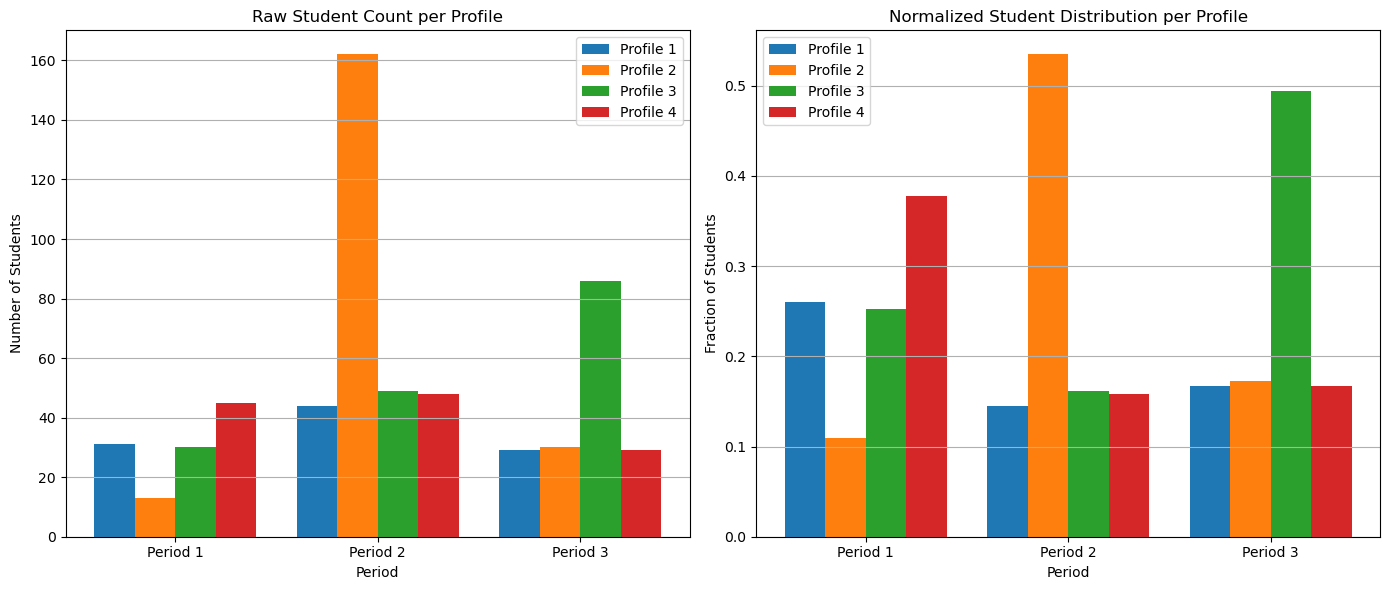

In [8]:
def cluster_students_by_period(students_by_period, k=4):
    """
    Applies KMeans clustering to students from each period and returns two bar plots:
    - absolute cluster distribution
    - normalized cluster distribution

    Parameters:
    -----------
    students_by_period : dict
        Dictionary of student dataframes for each period
    k : int, default=4
        Number of clusters to use

    Returns:
    --------
    dict
        Dictionary of clustered student dataframes per period
    """
    from collections import defaultdict
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.preprocessing import StandardScaler
    from sklearn.cluster import KMeans

    columns_used = [
        'median_gap_days',
        'active_days_count',
        'activities_count',
        'activity_types_count',
        'median_activity_duration_minutes'
    ]
    
    clustered_students = {}
    cluster_distributions = defaultdict(lambda: [0]*k)
    cluster_distributions_normalized = defaultdict(lambda: [0]*k)

    for period_name, df in students_by_period.items():
        if df is None or df.empty:
            continue
        
        df_clean = df.dropna(subset=columns_used)
        if len(df_clean) < k:
            continue
        
        X = df_clean[columns_used]
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(X_scaled)

        df_clean = df_clean.copy()
        df_clean['cluster'] = labels

        # Count cluster assignments
        counts = df_clean['cluster'].value_counts().sort_index()
        total = len(df_clean)
        for cluster_idx in range(k):
            count = counts.get(cluster_idx, 0)
            cluster_distributions[period_name][cluster_idx] = count
            cluster_distributions_normalized[period_name][cluster_idx] = count / total

        clustered_students[period_name] = df_clean

    # Plot side-by-side charts
    if clustered_students:
        periods_sorted = sorted(cluster_distributions.keys())
        x = np.arange(len(periods_sorted))
        width = 0.2

        fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=False)

        # Raw count plot
        for i in range(k):
            counts = [cluster_distributions[period][i] for period in periods_sorted]
            axes[0].bar(x + i * width, counts, width, label=f'Profile {i+1}')
        axes[0].set_title('Raw Student Count per Profile')
        axes[0].set_xlabel('Period')
        axes[0].set_ylabel('Number of Students')
        axes[0].set_xticks(x + width * (k-1)/2)
        axes[0].set_xticklabels(periods_sorted)
        axes[0].legend()
        axes[0].grid(axis='y')

        # Normalized plot
        for i in range(k):
            counts = [cluster_distributions_normalized[period][i] for period in periods_sorted]
            axes[1].bar(x + i * width, counts, width, label=f'Profile {i+1}')
        axes[1].set_title('Normalized Student Distribution per Profile')
        axes[1].set_xlabel('Period')
        axes[1].set_ylabel('Fraction of Students')
        axes[1].set_xticks(x + width * (k-1)/2)
        axes[1].set_xticklabels(periods_sorted)
        axes[1].legend()
        axes[1].grid(axis='y')

        plt.tight_layout()
        plt.show()

    return clustered_students

clustered_students_by_period = cluster_students_by_period(students_by_period, k=4)

In [ ]:
import plotly.graph_objects as go
import pandas as pd
import matplotlib.colors as mcolors

def plot_cluster_transition_sankey(clustered_students_by_period):
    sorted_periods = sorted(clustered_students_by_period.keys())
    
    # Step 1: Build long-format data (user_id, period, cluster)
    records = []
    for period in sorted_periods:
        df = clustered_students_by_period[period]
        for _, row in df[['user_id', 'cluster']].dropna().iterrows():
            records.append((row['user_id'], period, int(row['cluster'])))
    
    transition_df = pd.DataFrame(records, columns=['user_id', 'period', 'cluster'])
    pivot = transition_df.pivot(index='user_id', columns='period', values='cluster')

    # Step 2: Collect all (period, cluster) node labels, and assign label_index
    label_index = {}
    label_list = []
    node_colors = []
    color_palette = list(mcolors.TABLEAU_COLORS.values())  # Max 10; use other palettes if needed

    period_cluster_nodes = []
    all_cj_values = set()

    # Collect nodes grouped by period and sorted by cluster
    for period in sorted_periods:
        clusters = sorted(transition_df[transition_df['period'] == period]['cluster'].dropna().unique())
        for cluster in clusters:
            node_id = f"{period}_C{cluster}"
            label_index[node_id] = len(label_list)
            label_list.append(f"Profile {cluster + 1}")
            period_cluster_nodes.append((period, cluster))
            all_cj_values.add(cluster)

    # Assign consistent color per cluster number
    cj_sorted = sorted(all_cj_values)
    cj_to_color = {cj: color_palette[i % len(color_palette)] for i, cj in enumerate(cj_sorted)}
    node_colors = [cj_to_color[cluster] for _, cluster in period_cluster_nodes]

    # Step 3: Build source–target–value lists
    source = []
    target = []
    value = []

    for i in range(len(sorted_periods) - 1):
        p1, p2 = sorted_periods[i], sorted_periods[i + 1]
        transitions = pivot[[p1, p2]].dropna().astype(int)

        for (c1, c2), count in transitions.groupby([p1, p2]).size().items():
            label1 = f"{p1}_C{c1}"
            label2 = f"{p2}_C{c2}"
            source.append(label_index[label1])
            target.append(label_index[label2])
            value.append(count)

        # Step 4: Prepare hover text for links and nodes
        link_labels = []
        for i in range(len(source)):
            src_label = label_list[source[i]]
            tgt_label = label_list[target[i]]
            cnt = value[i]
            link_labels.append(f"{cnt} students went from {src_label} to {tgt_label}")

        # Count total per node for node hover text
        node_counts = [0] * len(label_list)
        for i in range(len(source)):
            node_counts[source[i]] += value[i]
            node_counts[target[i]] += value[i]

        node_hover = [f"{count} students are in {label}" for count, label in zip(node_counts, label_list)]

        # Step 5: Plot Sankey with custom hover texts
        fig = go.Figure(data=[go.Sankey(
            node=dict(
                pad=15,
                thickness=20,
                line=dict(color="rgba(0,0,0,0)", width=0.0),
                label=label_list,
                color=node_colors,
                hovertemplate='%{customdata}<extra></extra>',
                customdata=node_hover
            ),
            link=dict(
                source=source,
                target=target,
                value=value,
                hovertemplate='%{customdata}<extra></extra>',
                customdata=link_labels
            )
        )])


    fig.update_layout(title_text="Student Profile Transitions Over Time", font_size=10)
    fig.update_layout(title_x=0.5)
    fig.update_layout(margin=dict(l=40, r=40, t=70, b=40))
    fig.show()


plot_cluster_transition_sankey(clustered_students_by_period)

Metrics

In [11]:
def compute_combined_fluctuation_metrics(clustered_students_by_period):
    """
    Computes both raw and normalized (signed) cluster fluctuation metrics across periods.

    Returns:
        pd.DataFrame combining all metrics.
    """
    sorted_periods = sorted(clustered_students_by_period.keys())
    raw_metrics = []
    signed_metrics = []

    # Build wide format: one row per user with cluster per period
    records = []
    for period in sorted_periods:
        df = clustered_students_by_period[period]
        if df is not None:
            records.append(df[['user_id', 'cluster']].rename(columns={'cluster': period}))
    merged = records[0]
    for df in records[1:]:
        merged = pd.merge(merged, df, on='user_id', how='outer')

    # Compute metrics for each adjacent period pair
    for i in range(len(sorted_periods) - 1):
        p1, p2 = sorted_periods[i], sorted_periods[i + 1]
        sub = merged[[p1, p2]].dropna().astype(int)
        if sub.empty:
            continue

        diffs = sub[p2] - sub[p1]
        N = len(diffs)

        # Raw metrics
        positive_movement = (diffs < 0).sum()
        negative_movement = (diffs > 0).sum()
        positive_gain = (-diffs[diffs < 0]).sum()
        negative_drop = diffs[diffs > 0].sum()
        total_movement = abs(diffs).sum()

        raw_metrics.append({
            'from': p1,
            'to': p2,
            'n_users': N,
            'positive_gain_users': positive_movement,
            'positive_gain_total': positive_gain,
            'negative_drop_users': negative_movement,
            'negative_drop_total': negative_drop,
            'total_fluctuation': total_movement
        })

        # Signed + normalized metrics
        signed_movement = (-diffs).mean()
        avg_total_movement = abs(diffs).mean()

        pos_gains = -diffs[diffs < 0]
        neg_drops = diffs[diffs > 0]
        std_positive = pos_gains.std() if not pos_gains.empty else 0.0
        std_negative = neg_drops.std() if not neg_drops.empty else 0.0

        signed_metrics.append({
            'from': p1,
            'to': p2,
            'signed_avg_movement': signed_movement,
            'avg_total_movement': avg_total_movement,
            'std_positive_gain': std_positive,
            'std_negative_drop': std_negative
        })

    # Merge both metric sets
    df_raw = pd.DataFrame(raw_metrics)
    df_signed = pd.DataFrame(signed_metrics)
    combined_df = pd.merge(df_raw, df_signed, on=['from', 'to'])

    return combined_df

fluctuation_metrics = compute_combined_fluctuation_metrics(clustered_students_by_period)
print("\nFluctuation metrics:")
display(fluctuation_metrics)


Fluctuation metrics:


,from,to,n_users,positive_gain_users,positive_gain_total,negative_drop_users,negative_drop_total,total_fluctuation,signed_avg_movement,avg_total_movement,std_positive_gain,std_negative_drop
0,Period 1,Period 2,90,47,77,29,42,119,0.388889,1.322222,0.568198,0.736120
1,Period 2,Period 3,127,29,38,76,106,144,-0.535433,1.133858,0.660273,0.543543
